# Capstone 3 - Modeling

## Predict Product Alignment

### Create a classifier that will predict which product the complaint is aligned to 
- This will allow the end user of this model to be able to identify areas with a higher number of complaints with respect to others
- dimensionality reduction ideas
    - SVD
    - Latent semantic analysis (LSA) or linear discriminant analysis (LDA)
    - 

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample, class_weight
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
%matplotlib inline
plt.style.use('ggplot')

In [73]:
load_path = "/Users/joeboardman/Documents/Springboard/GitHub/CapstoneThree/data/processed/"
fig_save_path = "/Users/joeboardman/Documents/Springboard/GitHub/CapstoneThree/figures/"
os.chdir(load_path)
df_banks_filename = 'DW_complaints.csv'
df_banks = pd.read_csv(df_banks_filename, index_col=0)
#tfidf_train = pd.read_csv(tfidf_train_filename)
#tfidf_test = pd.read_csv(tfidf_test_filename)

In [74]:
# drop rows without a written complaint
df_banks = df_banks.sample(n=20000, random_state=34)
df_banks = df_banks.dropna(subset=['preprocessed_complaint']).reset_index(drop=True)
df_banks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Product                 20000 non-null  object 
 1   Issue                   20000 non-null  object 
 2   complaint_text          20000 non-null  object 
 3   Company                 20000 non-null  object 
 4   company_response        20000 non-null  object 
 5   disputed                20000 non-null  int64  
 6   complaint_ID            20000 non-null  int64  
 7   sentences               20000 non-null  int64  
 8   words                   20000 non-null  int64  
 9   special_chars           20000 non-null  int64  
 10  preprocessed_complaint  20000 non-null  object 
 11  polarity                20000 non-null  float64
 12  subjectivity            20000 non-null  float64
 13  sentiment_vader         20000 non-null  float64
dtypes: float64(3), int64(5), object(6)
mem

In [126]:
# train test split - categorize

X = df_banks.drop('Product', axis=1)
y = df_banks['Product']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)


In [127]:
print(X_train.shape)
print(y_train.shape)

(16000, 13)
(16000,)


In [128]:
# words to remove from stop words
stop_remove = ['no', 'not', "don't"]
stop_add = ['xx', 'xxxx', '00']

def add_or_remove_stop_words(remove_list, add_list):
    '''adding or removing multiple stop words instead of repetitive code'''
    
    global STOP_WORDS
    STOP_WORDS = stopwords.words('english')
    for i in range(len(remove_list)):
        STOP_WORDS.remove(remove_list[i])
    
    for i in range(len(add_list)):
        STOP_WORDS.append(add_list[i])
    
# remove negation stop words
add_or_remove_stop_words(stop_remove, stop_add)


In [129]:
# tfidf vectorizer

t0 = time()

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, stop_words=STOP_WORDS)
tfidf_train = tfidf_vectorizer.fit_transform(X_train.preprocessed_complaint)
tfidf_test = tfidf_vectorizer.transform(X_test.preprocessed_complaint)

# convert tfidf to dataframe 
tfidf_train = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_test = pd.DataFrame(tfidf_test.A, columns=tfidf_vectorizer.get_feature_names())

print('Runtime:', round((time() - t0) / 60,1), 'minutes')

Runtime: 0.4 minutes


In [133]:
# summarize old distribution
counter = Counter(y_train)
for k, v in counter.items():
    per = v / len(y_train) * 100
    print('Class = %s, n = %d (%.3f%%)' % (k, v, per))

Class = Consumer Loan, n = 3933 (24.581%)
Class = Bank account or service, n = 4164 (26.025%)
Class = Credit card or prepaid card, n = 5083 (31.769%)
Class = Credit reporting, n = 1409 (8.806%)
Class = Debt collection, n = 919 (5.744%)
Class = Other financial service, n = 492 (3.075%)


In [134]:
# over sample to get balanced dataset
t0 = time()
#y_train2 = LabelEncoder().fit_transform(y_train)

smote = SMOTE(random_state=34)
tfidf_sm, y_sm = smote.fit_resample(tfidf_train, y_train)
print(tfidf_sm.shape, y_sm.shape)
print('Runtime:', round((time() - t0) / 60,1), 'minutes')

(30498, 10000) (30498,)
Runtime: 13.8 minutes


In [136]:
# summarize new distribution
counter = Counter(y_sm)
for k, v in counter.items():
    per = v / len(y_sm) * 100
    print('Class=%s, n=%d (%.3f%%)' % (k, v, per))

Class=Consumer Loan, n=5083 (16.667%)
Class=Bank account or service, n=5083 (16.667%)
Class=Credit card or prepaid card, n=5083 (16.667%)
Class=Credit reporting, n=5083 (16.667%)
Class=Debt collection, n=5083 (16.667%)
Class=Other financial service, n=5083 (16.667%)


In [50]:
print(type(y_train))
print(type(tfidf_train))
print(tfidf_train.head())
print(tfidf_train.shape)

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
         10  10 days  100  1000   12   15   16   18   19   20  ...  \
0  0.000000      0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1  0.000000      0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2  0.000000      0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
3  0.000000      0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
4  0.034446      0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

   would receive  would take  write  wrong  xxxxxxxx  year     years  \
0            0.0         0.0    0.0    0.0       0.0   0.0  0.000000   
1            0.0         0.0    0.0    0.0       0.0   0.0  0.000000   
2            0.0         0.0    0.0    0.0       0.0   0.0  0.000000   
3            0.0         0.0    0.0    0.0       0.0   0.0  0.000000   
4            0.0         0.0    0.0    0.0       0.0   0.0  0.026065   

   years ago  yes  yet  
0        0.0  0.0  0.0  
1        0.0  0.0  0.0

In [ ]:
'''chi, p = chi2(tfidf_train, y_train)
print(chi)
print(p)'''

In [ ]:
'''dfo = pd.DataFrame(y_train)
y_train2 = pd.concat([y_train.drop(dfo, axis=1), pd.get_dummies(dfo)], axis=1)
y_train2.unique()'''

In [ ]:
'''# chi-squared test for feature selection and dimensionality reduction
# onehot encode target variable? index predictors same as target variable

X_names = tfidf_vectorizer.get_feature_names()
p_value_limit = 0.95

unique_y = ['Product_Bank account or service',
       'Product_Consumer Loan', 
       'Product_Credit card or prepaid card',
       'Product_Credit reporting', 
       'Product_Debt collection',
       'Product_Other financial service']

df_features = pd.DataFrame()
for cat in unique_y:
    chi2, p = chi2(tfidf_train, y_train)
    df_features = df_features.append(pd.DataFrame({"feature":X_names, "score":1-p, "y":cat}))
    df_features = df_features.sort_values(["y","score"], ascending=[True,False])
    df_features = df_features[df_features["score"]>p_value_limit]
X_names = df_features["feature"].unique().tolist()'''

# Model 1 - Random Forest Classifier
# ----------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------

In [ ]:
# assign class weights for imbalanced dataset


In [ ]:
# gridsearch on random forest 

max_depth = [5, 15, 30, 50, 100]
max_depth.append(None)
criterion = ('gini', 'entropy')
max_features = ('auto', 'sqrt')
min_samples_split = [2, 5, 7, 10]
min_samples_leaf = [1, 2, 4, 7, 10]

param_grid = {
    'max_depth':max_depth,
    'criterion':criterion,
    'max_features':max_features,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf
}

rf = RandomForestClassifier(random_state=34)

gs = GridSearchCV(rf, param_grid=param_grid, cv=3, verbose=2, n_jobs = -1)



In [160]:
# Random forest classifier to predict complaint category

t0 = time()
#y_train = y_train.ravel()
rf_classifier = RandomForestClassifier(random_state=34) #, class_weight='balanced'
rf_classifier.fit(tfidf_sm, y_sm)
y_pred_rf = rf_classifier.predict(tfidf_test)
y_pred_proba_rf = rf_classifier.predict_proba(tfidf_test)
print('Runtime:', round((time() - t0) / 60,1), 'minutes')

Runtime: 1.8 minutes


In [153]:
# 3-fold cross validation
cv_scores_rf = cross_val_score(rf_classifier, tfidf_sm, y_sm, scoring='accuracy', cv=3, n_jobs=-1)


In [154]:
# print cv scores
print('Cross Validation Accuracy Scores: ',cv_scores_rf)

Cross Validation Accuracy Scores:  [0.86867991 0.92297856 0.92819201]


                             precision    recall  f1-score   support

    Bank account or service       0.82      0.87      0.84      1026
              Consumer Loan       0.86      0.91      0.88       999
Credit card or prepaid card       0.83      0.83      0.83      1254
           Credit reporting       0.58      0.57      0.57       366
            Debt collection       0.67      0.51      0.58       235
    Other financial service       0.78      0.38      0.51       120

                   accuracy                           0.80      4000
                  macro avg       0.76      0.68      0.70      4000
               weighted avg       0.80      0.80      0.80      4000



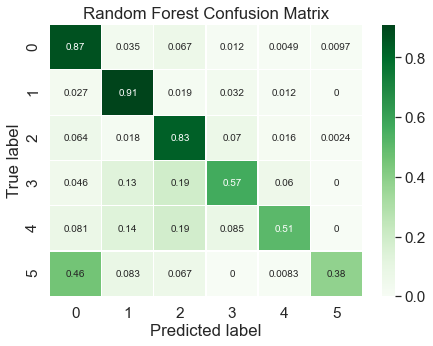

In [161]:
# classification report and confusion matrix for random forest model

print(classification_report(y_test, y_pred_rf, zero_division=0))

matrix = confusion_matrix(y_test, y_pred_rf)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
fig = plt.figure(figsize=(7,5))
sns.set(font_scale=1.4)
fig = sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Random Forest Confusion Matrix')
plt.show()

fig.figure.savefig(fig_save_path + 'rf_conf_matrix.png')
#With non-Upsampled data, 1000 features, using bank df

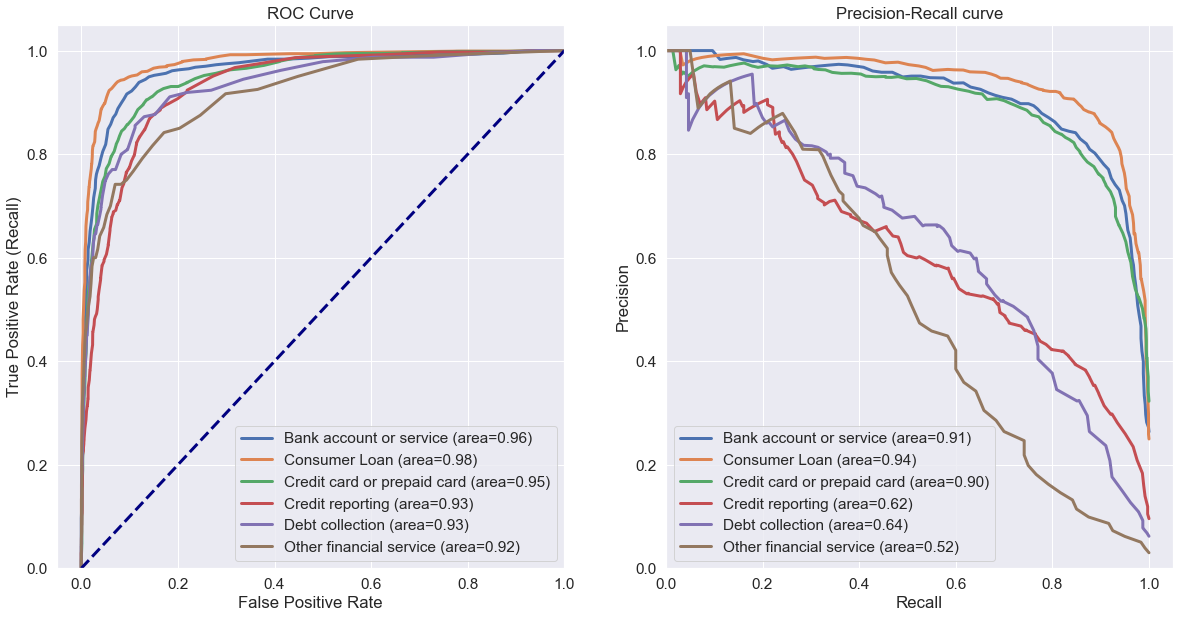

In [162]:
# Plot ROC and Precision-Recall curves
classes = np.unique(y_test)
y_test_array_rf = pd.get_dummies(y_test, drop_first=False).values

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array_rf[:,i],  
                           y_pred_proba_rf[:,i])
    ax1.plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              auc(fpr, tpr))
               )
ax1.plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax1.set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="ROC Curve")
ax1.legend(loc="lower right")
ax1.grid(True)

## Plot precision-recall curve
ax2 = fig.add_subplot(1,2,2)
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
                 y_test_array_rf[:,i], y_pred_proba_rf[:,i])
    ax2.plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  auc(recall, precision))
              )
ax2.set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax2.legend(loc="best")
ax2.grid(True)
plt.show()

fig.savefig(fig_save_path + 'rf_ROC_PR_curves.png')

# Model 2 - Naive Bayes Classifier
# ----------------------------------------------------------------------------
# ----------------------------------------------------------------------------

In [157]:
# Multinomial Naive Bayes classifier to predict complaint category

t0 = time()
#y_train = y_train.ravel()
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_sm, y_sm)
y_pred_nb = nb_classifier.predict(tfidf_test)
y_pred_proba_nb = nb_classifier.predict_proba(tfidf_test)
print('Runtime:', round((time() - t0) / 60,1), 'minutes')

Runtime: 0.1 minutes


In [155]:
# 3-fold cross validation
cv_scores_nb = cross_val_score(nb_classifier, tfidf_sm, y_sm, scoring='accuracy', cv=3, n_jobs=-1)

In [156]:
# print cv scores
print('Cross Validation Accuracy Scores: ',cv_scores_nb)

Cross Validation Accuracy Scores:  [0.81221719 0.8355302  0.8441865 ]


                             precision    recall  f1-score   support

    Bank account or service       0.87      0.78      0.82      1026
              Consumer Loan       0.90      0.87      0.88       999
Credit card or prepaid card       0.87      0.78      0.82      1254
           Credit reporting       0.53      0.67      0.59       366
            Debt collection       0.52      0.61      0.56       235
    Other financial service       0.37      0.74      0.49       120

                   accuracy                           0.78      4000
                  macro avg       0.67      0.74      0.70      4000
               weighted avg       0.81      0.78      0.79      4000



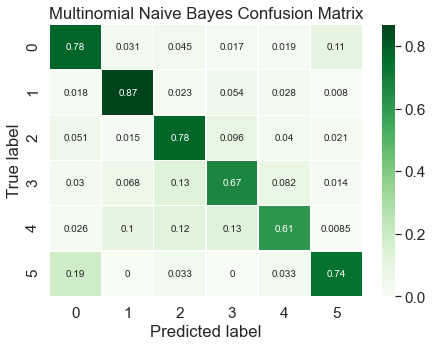

In [158]:
# classification report and confusion matrix for Multinomial Naive Bayes model

print(classification_report(y_test, y_pred_nb, zero_division=0))

matrix = confusion_matrix(y_test, y_pred_nb)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
fig = plt.figure(figsize=(7,5))
sns.set(font_scale=1.4)
fig = sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Multinomial Naive Bayes Confusion Matrix')
plt.show()

fig.figure.savefig(fig_save_path + 'nb_conf_matrix.png')
#With non-Upsampled data, 1000 features, using bank df

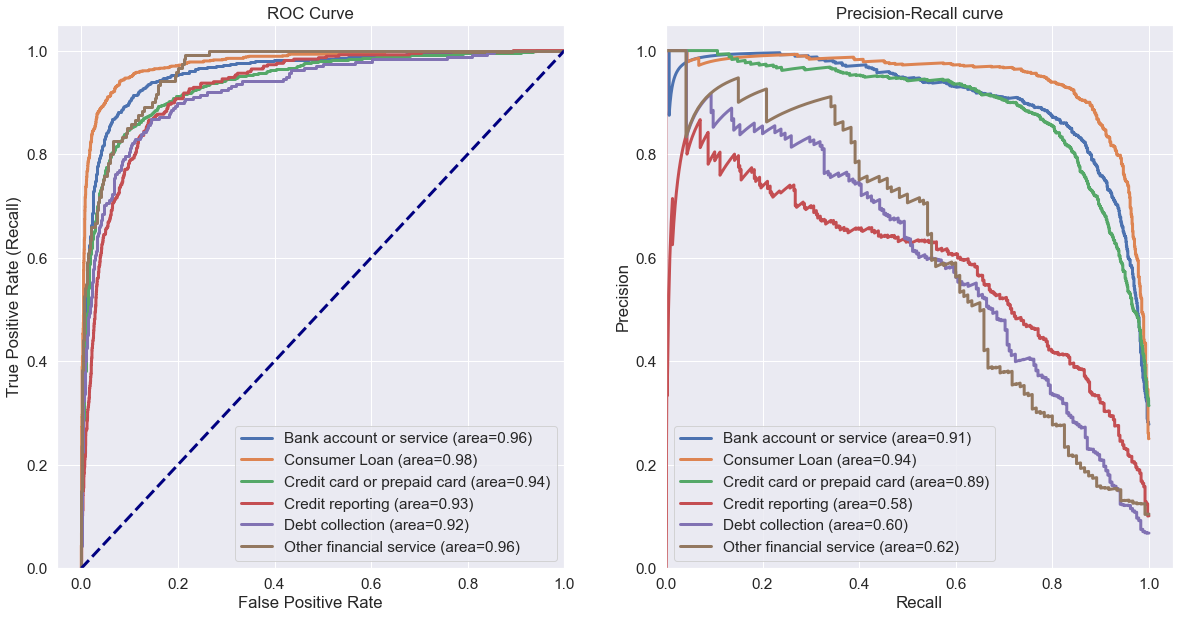

In [159]:
# Plot ROC and Precision-Recall curves
classes = np.unique(y_test)
y_test_array_nb = pd.get_dummies(y_test, drop_first=False).values

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array_nb[:,i],  
                           y_pred_proba_nb[:,i])
    ax1.plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              auc(fpr, tpr))
               )
ax1.plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax1.set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="ROC Curve")
ax1.legend(loc="lower right")
ax1.grid(True)

## Plot precision-recall curve
ax2 = fig.add_subplot(1,2,2)
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
                 y_test_array_nb[:,i], y_pred_proba_nb[:,i])
    ax2.plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  auc(recall, precision))
              )
ax2.set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax2.legend(loc="best")
ax2.grid(True)
plt.show()

fig.savefig(fig_save_path + 'nb_ROC_PR_curves.png')